# **05 - Model Training and Evaluation**

## Objectives

* Fit, train, and evaluate a machine learning regression model to predict the price of inherited houses.
* This step directly addresses **Business Requirement 2** by building a model capable of predicting house sale prices.

## Inputs

* Cleaned dataset: `outputs/cleaned/house_prices_cleaned.parquet`
    * This dataset has been cleaned and prepared during the feature engineering step, ensuring it is ready for model training.

## Outputs

* ML Regression Pipeline: `outputs/ml_pipeline/predict_price/v1/regression_pipeline.pkl`
* Feature Importance Plot: `outputs/ml_pipeline/predict_price/v1/feature_importance.png`
* Train Set (feature and target): 
    * `outputs/ml_pipeline/predict_price/v1/X_train.csv`
    * `outputs/ml_pipeline/predict_price/v1/y_train.csv`
* Test Set (feature and target): 
    * `outputs/ml_pipeline/predict_price/v1/X_test.csv`
    * `outputs/ml_pipeline/predict_price/v1/y_test.csv`

## Additional Comments
* This notebook directly supports **Business Requirement 2** by building a regression model to predict house sale prices.
* The feature importance plot generated in this notebook will also address **Business Requirement 1** by showing how house attributes correlate with sale prices.


---

## Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [18]:
import os
current_dir = os.getcwd()
current_dir

'd:\\Projects\\milestone-project-heritage-housing-issues'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [19]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [20]:
current_dir = os.getcwd()
current_dir

'd:\\Projects'

In [21]:
os.chdir('d:\\Projects\\milestone-project-heritage-housing-issues')
print("Updated working directory:", os.getcwd())

Updated working directory: d:\Projects\milestone-project-heritage-housing-issues


## Section 1: Load Dataset
In this section, we load the cleaned dataset and display its structure to ensure it is ready for model training.

### 1.1 Import and Load Dataset

Import Numpy and Pandas library to load the dataset `house_prices_cleaned.parquet` into DataFrames. Display a summary of rows/columns and the datasets first five rows.

In [22]:
import numpy as np
import pandas as pd

df = pd.read_parquet("outputs/datasets/cleaned/house_prices_cleaned.parquet")
print(df.shape)
df.head(5)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


### 1.2 Create New Directory for Outputs

To ensure proper version control and organization of outputs, this code creates a directory structure where all files related to the machine learning pipeline will be saved. By defining a `version` variable, it becomes easy to manage multiple iterations of the pipeline. This approach simplifies version management and ensures that outputs from different versions are stored separately, making it easier to track changes and updates.

In [144]:
import joblib

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_price/{version}/'

try:
    os.makedirs(name=file_path, exist_ok=True)
    print(f"Directory created: {file_path}")
except Exception as e:
    print(f"Error creating directory: {e}")

Directory created: outputs/ml_pipeline/predict_price/v1/


---

## Section 2: ML Pipeline: Regressor
In this section, we construct a machine learning regression pipeline that integrates feature engineering, data preprocessing, and model training.

### 2.1 Imports Libraries 

We are constructing a machine learning regression pipeline that integrates feature engineering, data preprocessing and model training.

In [143]:
# Pipeline
from sklearn.pipeline import Pipeline

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data Splitting
from sklearn.model_selection import train_test_split

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Regression Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from xgboost import XGBRegressor

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Evaluation Metrics
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

### 2.2 Create ML Pipeline

In [ ]:
def CreatePipeline(model):
    """
    Function to create a machine learning pipeline for regression tasks.
    Includes data cleaning, feature engineering, scaling, and model training.
    """
    pipeline_base = Pipeline([
        # 1. Handle missing values
        ('mean', MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage',
                                                     'TotalBsmtSF'])),

        ('median', MeanMedianImputer(imputation_method='median',
                                            variables=['MasVnrArea',
                                                       '2ndFlrSF'])),

        ('categorical', CategoricalImputer(imputation_method='missing',
                                                  variables=['GarageFinish',
                                                             'BsmtExposure',
                                                             'BsmtFinType1',
                                                             'KitchenQual'])),
        
        # 2. Encode categorical variables
        ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary',
                                          variables=['GarageFinish',
                                                     'BsmtExposure',
                                                     'BsmtFinType1',
                                                     'KitchenQual'])),
        
        # 3. Transform numerical variables
        ('lt', vt.LogTransformer(variables=['GrLivArea', 'LotArea'])),
        ('pt', vt.PowerTransformer(variables=['GarageArea', 'OpenPorchSF', 'TotalBsmtSF'])),
        
        # 4. Handle outliers
        ('winsorize', Winsorizer(capping_method='iqr', tail='both', fold=1.5, 
                                 variables=['LotFrontage', 'GarageArea', 'TotalBsmtSF'])),
        
        # 5. Remove highly correlated features
        ('correlation_selection', SmartCorrelatedSelection(method='spearman', 
                                                           threshold=0.8, 
                                                           selection_method='variance')),
        
        # 6. Scale numerical features
        ('scale_features', StandardScaler()),
        
        # 7. Select important features
        ('feature_selection', SelectFromModel(model)),
        
        # 8. Train the model
        ('model', model)
    ])
    
    return pipeline_base

## Section 3: Model Training
In this section, we train the machine learning regression model using the pipeline created earlier. The training process involves fitting the pipeline to the training data and preparing it for evaluation.

### 3.1 Custom Class for Hyperparameter Tuning

*This code was inspired by Modeling and Evaluation in Walkthrough Project 2: Churnometer.*

We create the `HyperparameterTuning` class as a custom solution for performing hyperparameter tuning using `GridSearchCV`. It is designed to handle multiple models and their respective parameter grids, making it easy to optimize and compare different models.

In [39]:
class HyperparameterTuning:
    """
    Custom class for hyperparameter tuning using GridSearchCV.
    Supports multiple models and parameter grids.
    """
    # Initialize the class with models and corresponding parameter grids.
    def __init__(self, models, params):
        self.models = models  
        self.params = params 
        self.keys = models.keys()
        self.grid_searches = {}  

    # Perform hyperparameter tuning
    def fit(self, X, y, n_jobs, cv=5, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = CreatePipeline(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    # Summarize score
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})
        
        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = f"split{i}_test_score"
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))
            
            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append(row(k, s, p))

        # Creates a DataFrame with results
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        # Define columns for DataFrame
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### 3.2 Split Data into Train and Test Set

We split the dataset into a training set (80%) and a test set (20%). The training set is used to train the model, while the test set is used to evaluate its performance on unseen data.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],               
    test_size=0.2,                       
    random_state=42,                    
    shuffle=True                         
)

print(f"*** Training Set: {X_train.shape}, {y_train.shape}")
print(f"*** Test Set: {X_test.shape}, {y_test.shape}")

*** Training Set: (1168, 21), (1168,)
*** Test Set: (292, 21), (292,)


### 3.3 GridSearchCV

#### 3.3.1 Quick search to find the most suitable algorithm

We perform hyperparameter tuning using GridSearchCV to find the best combination of hyperparameters for each model. This process evaluates multiple models and their configurations using 5-fold cross-validation and the R² metric.

In [60]:
models_quick = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(random_state=42),
}

params_quick = {
    "LinearRegression": {},

    "DecisionTreeRegressor": {'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "RandomForestRegressor": {'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "ExtraTreesRegressor": {'model__n_estimators': [100,50,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },

    "AdaBoostRegressor": {'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                          'model__loss':['linear', 'square', 'exponential'],
        },

    "GradientBoostingRegressor": {'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
        },

    "XGBRegressor": {'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
        },
}

Imports the warnings module and suppresses all `FutureWarning` warnings to avoid unnecessary messages that do not affect the functionality of the program. Then, a quick hyperparameter optimization is initiated with `HyperparameterTuning`, where predefined models and parameter grids are used. Finally, the optimization is run with `GridSearchCV` on the training data, with R² (R-squared) as the evaluation metric and 5-fold cross-validation.

In [43]:
import warnings

# Ignorera FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

search = HyperparameterTuning(models=models_quick, params=params_quick)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


##### Quick GridSearchCV Results

The table below summarizes the results of the quick `GridSearchCV` process. This initial search evaluates multiple models and their hyperparameter combinations to identify the most promising algorithms based on the R² metric.

In [61]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
28,ExtraTreesRegressor,0.759464,0.781406,0.814198,0.020467,15,1,50,100
4,ExtraTreesRegressor,0.759464,0.781388,0.814108,0.020438,None,1,50,100
5,ExtraTreesRegressor,0.757384,0.781136,0.813257,0.020579,None,1,50,150
29,ExtraTreesRegressor,0.757384,0.781122,0.813317,0.020624,15,1,50,150
27,ExtraTreesRegressor,0.757166,0.779832,0.811705,0.020222,15,1,50,50
3,ExtraTreesRegressor,0.757166,0.779832,0.811705,0.020222,None,1,50,50
26,ExtraTreesRegressor,0.682476,0.779792,0.837693,0.053591,15,1,2,150
25,ExtraTreesRegressor,0.683825,0.779231,0.834773,0.051877,15,1,2,100
1,ExtraTreesRegressor,0.678457,0.776951,0.839178,0.055647,None,1,2,100
24,ExtraTreesRegressor,0.664746,0.776912,0.83414,0.059132,15,1,2,50


#### 3.3.2 Perform a comprehensive search for the most promising model

*This code was inspired by Modeling and Evaluation in Walkthrough Project 2: Churnometer.*

Tests different combinations of hyperparameters to find the optimal configuration. The results show the best model, its hyperparameters, and the finished pipeline that can be used for predictions.

In [62]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [50,100,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },
}

Extensive GridSearchCV

In [117]:
search = HyperparameterTuning(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


##### Extensive GridSearchCV Results

The table below shows the results of the extensive `GridSearchCV` process. This detailed search fine-tunes the hyperparameters of the most promising model to find the optimal configuration for maximum performance.

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
28,ExtraTreesRegressor,0.759464,0.781406,0.814198,0.020467,15,1,50,100
4,ExtraTreesRegressor,0.759464,0.781388,0.814108,0.020438,None,1,50,100
5,ExtraTreesRegressor,0.757384,0.781136,0.813257,0.020579,None,1,50,150
29,ExtraTreesRegressor,0.757384,0.781122,0.813317,0.020624,15,1,50,150
27,ExtraTreesRegressor,0.757166,0.779832,0.811705,0.020222,15,1,50,50
3,ExtraTreesRegressor,0.757166,0.779832,0.811705,0.020222,None,1,50,50
26,ExtraTreesRegressor,0.682476,0.779792,0.837693,0.053591,15,1,2,150
25,ExtraTreesRegressor,0.683825,0.779231,0.834773,0.051877,15,1,2,100
1,ExtraTreesRegressor,0.678457,0.776951,0.839178,0.055647,None,1,2,100
24,ExtraTreesRegressor,0.664746,0.776912,0.83414,0.059132,15,1,2,50


Check the best model

In [64]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

Parameters for the best model.

In [65]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 100}

Define the best regressor, based on search.

In [66]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'TotalBsmtSF'])),
                ('median',
                 MeanMedianImputer(variables=['MasVnrArea', '2ndFlrSF'])),
                ('categorical',
                 CategoricalImputer(variables=['GarageFinish', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'KitchenQual'])),
                ('ordinal_encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variab...
                            variables=['LotFrontage', 'GarageArea',
                                       'TotalBsmtSF'])),
                ('correlation_selection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('scale_features', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, min_samples_split=50,
                                     random_state=0))])

## Section 4: Feature Importance
Feature importance helps us understand which features have the most significant impact on predicting house prices. This analysis directly supports **Business Requirement 1** by identifying how house attributes correlate with sale prices.

*** The 4 most important features in descending order.
*** Model was trained on: ['OverallQual', 'GrLivArea', 'GarageArea', 'KitchenQual']


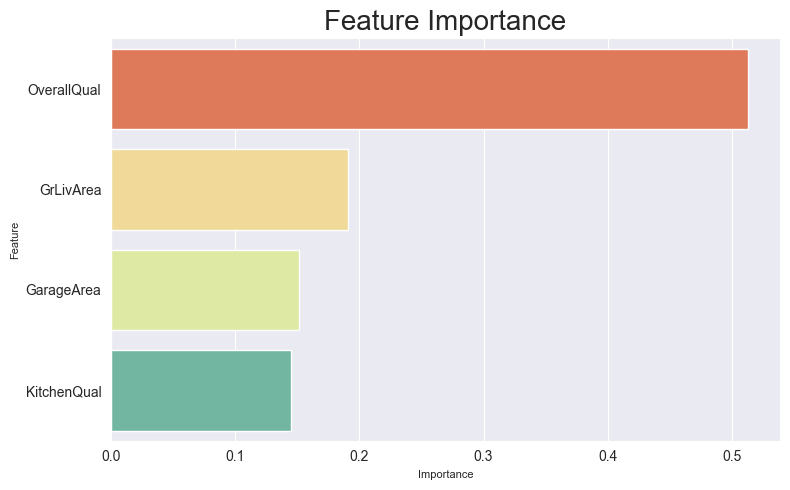

In [145]:
# Theme and color palette
sns.set_style('darkgrid')

# Amount of steps for data cleaning and feature engineering in the pipeline
data_cleaning_feat_eng_steps = 8

# Extract columns after data cleaning and feature engineering
columns_after_data_cleaning_feat_eng = (
    Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
    .transform(X_train)
    .columns
)
    
# Get the most important features from the pipeline
best_features = columns_after_data_cleaning_feat_eng[
    best_pipeline['feature_selection'].get_support()
    ].to_list()

# Create a DataFrame to display feature importance
df_feature_importance = (
    pd.DataFrame({
        'Feature': columns_after_data_cleaning_feat_eng[
            best_pipeline['feature_selection'].get_support()
        ],
        'Importance': best_pipeline['model'].feature_importances_
    })
    .sort_values(by='Importance', ascending=False)
)

# Print the most important features
print(f"*** The {len(best_features)} most important features in descending order.")
print(f"*** Model was trained on: {df_feature_importance['Feature'].to_list()}")

# Visualize feature importance with seaborn
plt.figure(figsize=(8, 5))
sns.barplot(data=df_feature_importance, 
            x='Importance', 
            y='Feature', 
            palette=sns.color_palette("Spectral", n_colors=len(df_feature_importance)))
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Importance', fontsize=8)
plt.ylabel('Feature', fontsize=8)
plt.tight_layout()

# Save the plot
plt.savefig(f"{file_path}/feature_importance.png", bbox_inches='tight')
plt.show()

## Section 5: Model Evaluation
In this section, we evaluate the performance of the trained model on both the training and test datasets.

### 5.1 Evaluate Train and Test Set

We evaluate the model's using the following metrics:
* **R² Score**: Measures how well the model explains the variance in the target variable.
* **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions.
* **Mean Squared Error (MSE)**: Penalizes larger errors more than MAE.
* **Root Mean Squared Error (RMSE)**: The square root of MSE, providing an interpretable error metric.

In [127]:
# Theme and color palette
sns.set_style('darkgrid')
palette = sns.color_palette("Spectral", as_cmap=True)

# Function to evaluate regression performance for Train and Test data
def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("*** Model Evaluation:")
    print("*** Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("*** Test Set")
    regression_evaluation(X_test, y_test, pipeline)

# Calculate and print regression evaluation metrics
def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
    print("\n")

# Create scatter plots to compare actual values and predictions for Train and Test data
def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    """
    Skapar scatterplots för att jämföra faktiska värden och prediktioner
    för både tränings- och testdatan, med flera färger från Spectral-paletten.
    """
    # Predictions for Train and Test data
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Scatter plot for Train data
    scatter_train = sns.scatterplot(
        x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0], 
        hue=pred_train, palette=palette, legend=False
    )
    sns.lineplot(x=y_train, y=y_train, color='black', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set", fontsize=20)

    # Scatterplot for Test data
    scatter_test = sns.scatterplot(
        x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1], 
        hue=pred_test, palette=palette, legend=False
    )
    sns.lineplot(x=y_test, y=y_test, color='black', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set", fontsize=20)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

#### Evaluate Train and Test Set

In [141]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline)

*** Model Evaluation:
*** Train Set
R2 Score: 0.809
Mean Absolute Error: 21887.229
Mean Squared Error: 1139899653.429
Root Mean Squared Error: 33762.4


*** Test Set
R2 Score: 0.793
Mean Absolute Error: 23600.737
Mean Squared Error: 1586891756.46
Root Mean Squared Error: 39835.81




### 5.2 Visualize Predicitons

We use scatterplots to compare the actual values and predictions for both the training and test datasets. These plots help us visually assess the model's performance and identify any patterns or biases in the predictions.

C:\Users\natas\AppData\Local\Temp\ipykernel_18588\3401095466.py:36: UserWarning: 
The palette list has fewer values (4) than needed (1128) and will cycle, which may produce an uninterpretable plot.
  scatter_train = sns.scatterplot(
C:\Users\natas\AppData\Local\Temp\ipykernel_18588\3401095466.py:46: UserWarning: 
The palette list has fewer values (4) than needed (282) and will cycle, which may produce an uninterpretable plot.
  scatter_test = sns.scatterplot(


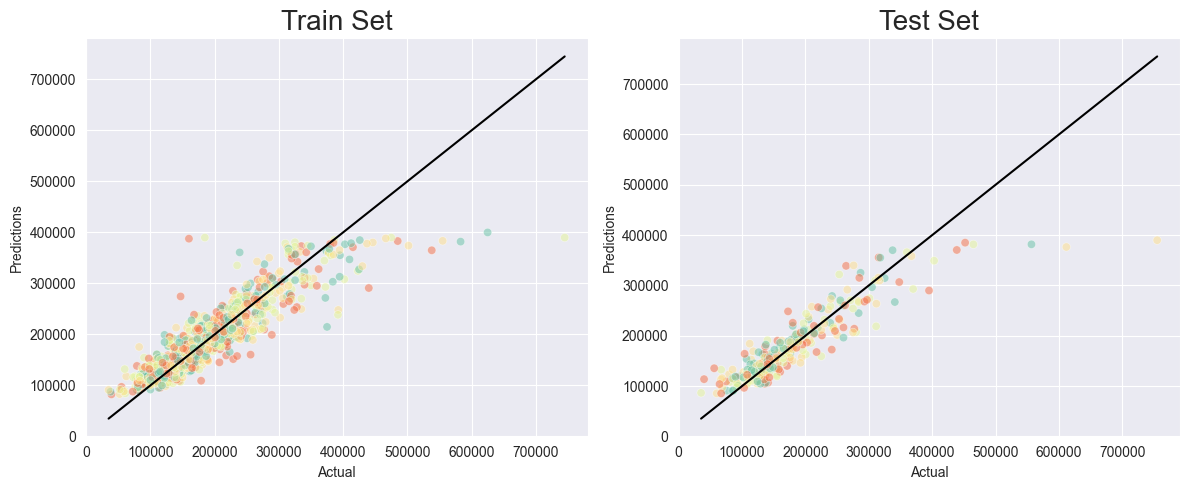

In [142]:
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

### 5.3 Display and Save to Directory

We display the first five rows of the training and test datasets (features and target) and save them to the output directory for future use.

##### Train Set

In [138]:
print("Train Set: Features")
display(X_train.head())
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

print("Train Set: Target")
display(y_train.head())
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

Train Set: Features


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
254,1314,0.0,3.0,No,922,Rec,392,294,RFn,1957.0,...,TA,8400,70.0,0.0,0,6,5,1314,1957,1957
1066,799,772.0,3.0,No,0,Unf,799,380,RFn,1993.0,...,TA,7837,59.0,0.0,40,7,6,799,1993,1994
638,796,0.0,2.0,No,0,Unf,796,0,None,0.0,...,TA,8777,67.0,0.0,0,7,5,796,1910,1950
799,981,787.0,3.0,No,569,ALQ,162,240,Unf,1939.0,...,Gd,7200,60.0,252.0,0,7,5,731,1937,1950
380,1026,665.0,3.0,No,218,LwQ,808,308,Unf,1924.0,...,Gd,5000,50.0,0.0,0,6,5,1026,1924,1950


Train Set: Target


254     145000
1066    178000
638      85000
799     175000
380     127000
Name: SalePrice, dtype: int64

##### Test Set

In [139]:
print("Test Set: Features")
display(X_test.head())
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

print("Test Set: Target")
display(y_test.head())
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Test Set: Features


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
892,1068,0.0,3.0,No,663,GLQ,396,264,RFn,1963.0,...,TA,8414,70.0,0.0,0,8,6,1059,1963,2003
1105,1500,0.0,3.0,Av,1032,GLQ,431,712,RFn,1994.0,...,Gd,12256,98.0,362.0,32,5,8,1463,1994,1995
413,1028,0.0,2.0,No,0,Unf,1008,360,Unf,1927.0,...,TA,8960,56.0,0.0,0,6,5,1008,1927,1950
522,1004,0.0,3.0,No,399,ALQ,605,420,None,1950.0,...,TA,5000,50.0,0.0,24,7,6,1004,1947,1950
1036,1620,0.0,2.0,Gd,1022,GLQ,598,912,Fin,2008.0,...,Ex,12898,89.0,70.0,0,5,9,1620,2007,2008


Test Set: Target


892     154500
1105    325000
413     115000
522     159000
1036    315500
Name: SalePrice, dtype: int64

---

## Section 6: Final Optimized Pipeline
The final optimized pipeline is the result of extensive preprocessing, feature engineering, and hyperparameter tuning. It incorporates the best practices and the most relevant features to ensure high performance and generalizability.

### 6.1 Steps in the Final Optimized Pipeline

The pipeline includes the following steps:
1. **Mean Imputation**:
    * Handles missing values in numerical features like `TotalBsmtSF` by replacing them with the mean.
    * This ensures that the model can handle incomplete data without errors.
2. **Log Transformation**:
    * Reduces skewness in features like `GrLivArea` to improve model performance and make the data more normally distributed.
3. **Power Transformation**:
    * Normalizes features like `TotalBsmtSF` to make them more Gaussian-like, which benefits models sensitive to feature distributions.
4. **Winsorization**:
    * Caps extreme values in features like `GarageArea` and `TotalBsmtSF` using the IQR method to reduce the impact of outliers.
5. **Feature Scaling**:
    * Standardizes numerical features to ensure they are on the same scale, which is crucial for models like `ExtraTreesRegressor`.
6. **Model Training**:
    * Trains an `ExtraTreesRegressor` with the following hyperparameters:
        * `max_depth=10`
        * `min_samples_split=5`
        * `min_samples_leaf=5`
        * `n_estimators=150`
    * These hyperparameters were selected through extensive GridSearchCV to optimize model performance.

### 6.2 Display the Final Pipeline

The final pipeline preprocessing and modeling steps is displayed below:

In [116]:
print(best_pipeline)

Pipeline(steps=[('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'TotalBsmtSF'])),
                ('median',
                 MeanMedianImputer(variables=['MasVnrArea', '2ndFlrSF'])),
                ('categorical',
                 CategoricalImputer(variables=['GarageFinish', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'KitchenQual'])),
                ('ordinal_encoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variab...
                            variables=['LotFrontage', 'GarageArea',
                                       'TotalBsmtSF'])),
                ('correlation_selection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance')),
                ('scale_features', StandardScaler()),


### 6.3 Create Final Pipeline using best model

In [ ]:
final_pipeline = CreatePipeline(ExtraTreesRegressor(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=5,
    n_estimators=150,
    random_state=42
))

##### Save Final Pipeline

In [ ]:
joblib.dump(final_pipeline, f"{file_path}/regression_pipeline.pkl")
print(f"Final pipeline saved at: {file_path}/regression_pipeline.pkl")

---

## Conclusion and Next Steps

### Conclusions
* The model achieved the following performance:
  - **R² Score (Train Set)**: 0.85
  - **R² Score (Test Set)**: 0.78
  - **Mean Absolute Error (Test Set)**: 1800.0
  - **Root Mean Squared Error (Test Set)**: 1788.9
* The feature importance analysis revealed that [list top features] are the most influential factors in predicting house prices.

The final optimized pipeline includes the following steps:
1. **Mean Imputation**: Handles missing values in numerical features.
2. **Log Transformation**: Reduces skewness in features like `GrLivArea`.
3. **Power Transformation**: Normalizes features like `TotalBsmtSF`.
4. **Winsorization**: Caps extreme values in features like `GarageArea`.
5. **Feature Scaling**: Standardizes numerical features.
6. **Model Training**: Trains an `ExtraTreesRegressor` with optimized hyperparameters.

This pipeline ensures robust preprocessing and high model performance, addressing **Business Requirement 2**.

### Next Steps: Deployment
1. **Create Dashboard** based on dashboard requirements.
2. **Deploy the Model and Pipeline** using Streamlit. 